# **Starting**

**Imports**

In [19]:
import tensorflow as tf
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model

**TPU enabling**

In [3]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

**Load Data**

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 

**Normalize**

In [46]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0  #range twn pixel = [0,255]
x_test = x_test / 255.0

**One hot encoding**

In [47]:
y_train =  tf.keras.utils.to_categorical(y_train)   #metatropi se dianusma me 10 diastaseis
y_test =  tf.keras.utils.to_categorical(y_test)

**OPTIONAL:**

Μετατρέπουμε σε grayscale το training και το test sample για να μειωθούν οι διαστάσεις τους (πχ. το x_train απο (50000,32,32,3) σε (50000,32,32) , δηλαδή να αντικαταστήσουμε το RGB που θέλει 3 νούμερα με grayscale) ώστε να έχουμε καλύτερο runtime και ιδανικά παρόμοιες/ίδιες αποδόσεις

In [7]:
# x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
# x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
# print(x_train.shape)

**Βλέπουμε πως είναι το grayscale image**

In [8]:
# plt.imshow(x_train[0], cmap='gray')

# **FULLY CONNECTED DENSE NEURAL NETWORK**

**Model setup**

Κάνουμε define την αρχιτεκτονική του δικτύου (Dense fully connected)
*    τα layers
*    τους νευρώνες
*    τις activation functions τους
*    το initialization
*    το loss

In [ ]:
#glorot for sigmoid kai tanh
#he for ReLU

#strategy = tf.distribute.TPUStrategy(resolver) #for tpu, the strategy to handle and process the data.

#initializer = tf.keras.initializers.HeNormal() #the starting values of the weights
kernel_regularizer=tf.keras.regularizers.L2(0.001)

#with strategy.scope(): # for tpu, indent the whole other block of code 
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  #reduce the dimensions of the input sample to a matrix
    tf.keras.layers.Dense(4000, activation='relu', kernel_initializer = 'he_uniform', bias_initializer='zeros', kernel_regularizer= kernel_regularizer ),  #dense layers
    tf.keras.layers.Dense(1000, activation= 'linear'),
    tf.keras.layers.Dense(4000, activation= 'relu', kernel_initializer = 'he_uniform', bias_initializer='zeros', kernel_regularizer= kernel_regularizer),
    tf.keras.layers.Dense(10, activation= 'softmax')    #classification layer
])

optimizer = tf.keras.optimizers.Adam()  #the way our model learns

loss = tf.keras.losses.CategoricalCrossentropy()  #the way we measure loss

model.compile(optimizer= optimizer,
              loss=loss,
              metrics=['accuracy'])

# model.summary()

**Σταματάμε το μοντέλο όταν φτάσει προσεγιστικά στο minimum**

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1,
    mode='min', restore_best_weights= True)

**Αποθηκεύουμε το μοντέλο με το καλύτερο accuracy στο test set**

In [ ]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

**Αποθηκεύουμε τα αποτελέσματα του training σε csv**

In [ ]:
logger = tf.keras.callbacks.CSVLogger('training.log', separator=',', append=True)

**Feeding the model**

Define το batch size και τις εποχές εκπαίδευσης

In [ ]:
history = model.fit(x_train, y_train, batch_size = 500, epochs = 30, shuffle = True,validation_data= (x_test, y_test), callbacks=[logger,early,model_checkpoint_callback], verbose= 2)

**Run: Dense network with encoded dataset**

In [ ]:
# history = model.fit(predEncodTrain, y_train, batch_size = 500, epochs = 10, shuffle = True,validation_data= (predEncodTest, y_test), callbacks=[logger], verbose= 2) #run encoded dataset

**Accuracy of the model**

In [ ]:
test_accuracy = model.evaluate(x_test,  y_test, verbose=2) #based on the last epoch weights
print('\nTest Accuracy = ',test_accuracy)

**Best accuracy**

In [ ]:
best = np.argmax(history.history['val_accuracy'])
print('The best accuracy is:',round(history.history['val_accuracy'][best],4),' in the ', best+1, 'epoch')


**Plots**

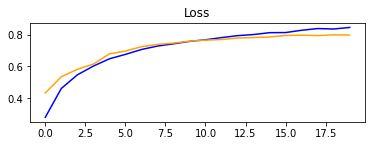

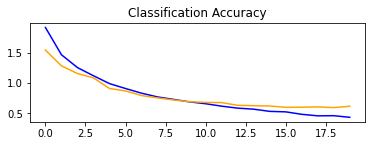

In [43]:
#plot accuracy
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()
#plot loss
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

**Confusion Matrix**

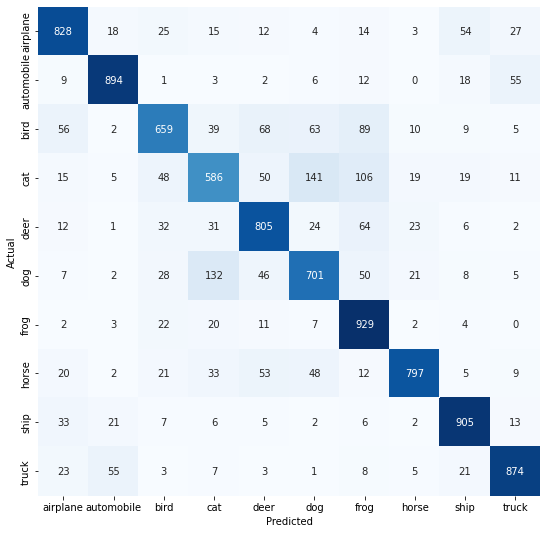

In [48]:
predictions = model.predict(x_test)

predictions = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, predictions)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **AUTOENCODER**

**Model setup**

Κάνουμε define την αρχιτεκτονική του δικτύου (Dense/Convolutional)
*    τα layers
*    τους νευρώνες
*    το filter
*    το kernel size
*    το stride
*    τις activation functions τους
*    το initialization
*    το loss

**Dense AutoEncoder** (best results)

In [ ]:
#strategy = tf.distribute.TPUStrategy(resolver) #for tpu, the strategy to handle and process the data.

#with strategy.scope(): # for tpu

#Dense

latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim, activation='sigmoid'),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(3072, activation='sigmoid'),
      tf.keras.layers.Reshape((32, 32, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])



#autoencoder.encoder.summary()
#autoencoder.decoder.summary()

**Convolution-Dense AutoEncoder**

In [ ]:
# Conv-Dense

latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, 5, activation='relu',strides=2, input_shape=(32,32,3), padding= 'same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = 'sigmoid')
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((2,2,128)),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(32, 5,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(3, 5,strides= 2, padding = 'same', activation="sigmoid"),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])


**Convolution-Deconvolution AutoEncoder**

In [ ]:
latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, 3, activation='relu',strides=2, input_shape=(32,32,3), padding= 'same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Conv2D(128, 3,activation = 'relu', strides = 2 , padding= 'same'),
      tf.keras.layers.MaxPool2D((2,2))
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((2,2,128)),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(32, 5,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(3, 5,strides= 2, padding = 'same', activation="sigmoid"),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])

**Feeding the model**

Define το batch size και τις εποχές εκπαίδευσης

In [ ]:
autoencoder.fit(x_train, x_train,    #apo x_train --- stoxos to x_train pali
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 2)

**Accuracy of the model**

In [ ]:
test_accuracy = autoencoder.evaluate(x_train,  x_train, verbose=2)
print('\nTest Accuracy = ',test_accuracy)

**Best accuracy**

In [ ]:
best = np.argmax(history.history['val_accuracy'])
print('The best accuracy is:',round(history.history['val_accuracy'][best],4),' in the ', best+1, 'epoch')

**Encoding our images**


In [ ]:
predicted = autoencoder.predict(x_test)
predEncodTest= autoencoder.encoder.predict(x_test)
predEncodTrain = autoencoder.encoder.predict(x_train)

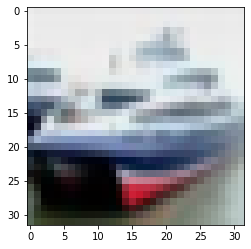

In [ ]:
plt.imshow(x_test[1])

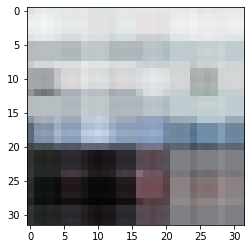

In [ ]:
plt.imshow(predicted[1])

**This works only for dense autoencoders**

In [ ]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs_test = autoencoder.decoder(encoded_imgs).numpy()

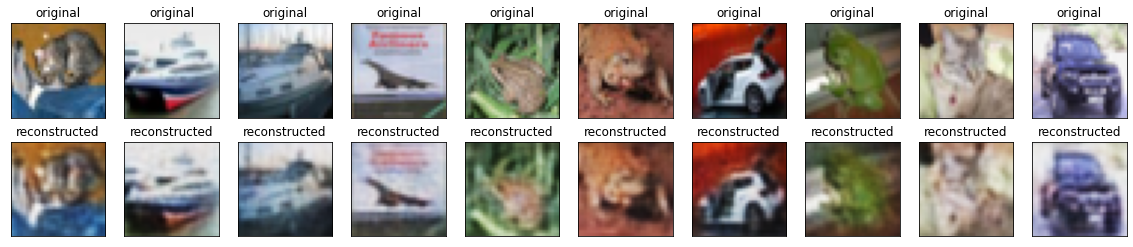

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_test[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# **CONVOLUTIONAL NEURAL NETWORK**

**Model setup**

Κάνουμε define την αρχιτεκτονική του δικτύου (Convolutional)
*    τα layers
*    τους νευρώνες
*    το filter
*    το kernel size
*    το stride
*    τις activation functions τους
*    το initialization
*    το loss

**Τυχαίο δίκτυο από τα αρχικά πειράματα**

In [ ]:
# strategy = tf.distribute.TPUStrategy(resolver) #for tpu, the strategy to handle and process the data.

# with strategy.scope(): # for tpu
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(32,32,3)), #convolutional
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),   #mean του convolution reduced σε n x n
  tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
  tf.keras.layers.Dropout(0.25),  #πιθανότητα του κάθε νευρώνα να "σβήσει" 
  tf.keras.layers.Flatten(),    #dense
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

optimizer = tf.keras.optimizers.Adam()  #the way our model learns

loss = tf.keras.losses.CategoricalCrossentropy(from_logits= False)  #the way we measure loss

model.compile(optimizer= optimizer,
              loss=loss,
              metrics=['accuracy'])


**Απλό δίκτυο**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, [3, 3], padding = 'same', strides= 2, activation='relu',kernel_initializer= 'he_uniform', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, [3, 3], padding = 'same', strides= 2, activation='relu',kernel_initializer= 'he_uniform', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu', kernel_initializer= 'he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

optimizer = tf.keras.optimizers.Adam()  #the way our model learns

loss = tf.keras.losses.CategoricalCrossentropy(from_logits= False)  #the way we measure loss

model.compile(optimizer= optimizer,
              loss=loss,
              metrics=['accuracy'])


**Βασικό δίκτυο πειραμάτων**

In [9]:
#Baseline Model 3 blocks

regularizer= None   #tf.keras.regularizers.L2(0.001)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same', input_shape=(32, 32, 3)),
	tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same'),
	tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same'),
	tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same'),
	tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same'),
	tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer, padding='same'),
	tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform',kernel_regularizer= regularizer),
	tf.keras.layers.Dense(10, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam()  #the way our model learns

loss = tf.keras.losses.CategoricalCrossentropy(from_logits= False)  #the way we measure loss

model.compile(optimizer= optimizer,
              loss=loss,
              metrics=['accuracy'])

# model.summary()

**Σταματάμε το μοντέλο όταν φτάσει προσεγιστικά στο minimum**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

**Αποθηκεύουμε το μοντέλο με το καλύτερο accuracy στο test set**

In [ ]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

**Reducing Learning Rate**

In [ ]:
lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_delta=0.0001)

**Feeding the model**

Define το batch size και τις εποχές εκπαίδευσης

In [ ]:
history = model.fit(x_train, y_train, batch_size = 500, epochs = 20, shuffle = True,validation_data= (x_test, y_test),callbacks=[es, model_checkpoint_callback, lr] verbose= 2)

In [10]:
model.save('Baseline_Conv_DropVar.h5')

**Plots**

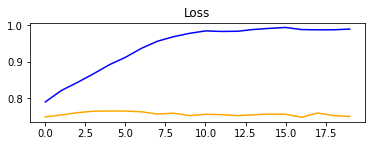

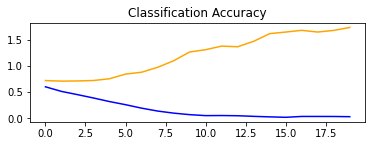

In [ ]:
#plot accuracy
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()
#plot loss
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

**Confusion Matrix**

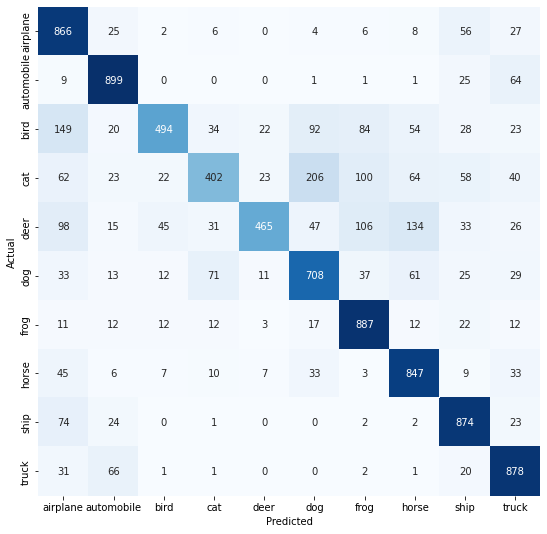

In [41]:
predictions = model.predict(x_test)

predictions = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, predictions)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Data Augmentation Training**

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(x_train, y_train, batch_size=500)

steps = int(x_train.shape[0] / 500)
history = model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(x_test, y_test), verbose=2)